In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
_FOLDER = "../data/"
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import json

In [75]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
#     fig = plt.figure(figsize=(5, 5))
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [76]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCL.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [77]:
len(trainTestSplit.keys())

88

In [96]:
# filterPlateau = filterPlateau[~filterPlateau['DRUG_ID'].isin(toDropDrugs)]
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC']
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels
ridgeResults = pd.DataFrame(columns=fullPredLabels)
lassoResults = pd.DataFrame(columns=fullPredLabels)
combinedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels)
df = None
for drugId in trainTestSplit.keys():
    drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
    trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
    testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
    testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
    notXValuesFilter = resp_labels + notIncludeColumns
    trainXValues = trainData.drop(columns = notXValuesFilter)
    trainYValues = trainData[resp_labels]
    
    trainX = trainXValues.reset_index(drop=True).to_numpy()
    trainY = trainYValues.reset_index(drop=True).to_numpy()
    
    testXValues = testData.drop(columns = notXValuesFilter)
    testYValues = testData[resp_labels]
    
    testX = testXValues.reset_index(drop=True).to_numpy()
    testY = testYValues.reset_index(drop=True).to_numpy()
    
    ridge = Ridge(alpha=0.01)
    ridge.fit(trainX, trainY)
    pred_train = ridge.predict(trainX)
    pred_test= ridge.predict(testX)
    resultsRidge = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsRidge[pred_resp_labels] = pred_test
    ridgeResults = ridgeResults.append(resultsRidge,ignore_index=True,sort=False)
    
    lasso = Lasso(alpha=0.01)
    lasso.fit(trainX, trainY)
    pred_trainL = lasso.predict(trainX)
    pred_testL= lasso.predict(testX)
    resultsLasso = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsLasso[pred_resp_labels] = pred_testL
    lassoResults = lassoResults.append(resultsLasso,ignore_index=True,sort=False)
    
    trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    trueResult[resp_labels] = testY
    trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)
    
    
    combinedResult = np.add(pred_test, pred_testL)
    divide2 = lambda i: float(i) / 2

    vectorized_divide2 = np.vectorize(divide2)

    combinedResult = np.asmatrix(vectorized_divide2(combinedResult))
    resultsComb = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsComb[pred_resp_labels] = combinedResult
    combinedResults = combinedResults.append(resultsComb,ignore_index=True,sort=False)
    
    

C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

In [97]:
lassoResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,1.0,1.007510,0.988981,0.969191,0.850071,0.602294,0.213139,0.088101,0.009848,0.009244
1,344_717431,1.0,1.007510,0.988981,0.911428,0.714871,0.461417,0.209269,0.078719,0.009848,0.009244
2,344_910925,1.0,1.007510,0.988981,0.969191,0.850071,0.631590,0.211524,0.081700,0.009848,0.009244
3,344_908457,1.0,1.007510,0.988981,0.969191,0.916852,0.694324,0.223136,0.097910,0.009848,0.009244
4,344_910853,1.0,1.007510,0.988981,0.969191,0.893819,0.761660,0.307754,0.200845,0.009848,0.009244
...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,1.009783,0.982038,0.993542,0.904785,0.805534,0.478593,0.305115,0.126874,0.114427
1151,330_908146,1.0,1.009783,0.961549,0.956647,0.706103,0.784882,0.371991,0.329328,0.126874,0.114427
1152,330_949088,1.0,1.009783,0.944557,0.956647,0.706103,0.724511,0.478593,0.305115,0.126874,0.114427
1153,1058_753531,1.0,1.006294,0.941744,0.857669,0.750162,0.548229,0.412580,0.281565,0.143813,0.134949


In [98]:
ridgeResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,1.0,0.995239,0.967838,0.893714,0.855743,0.829483,0.229350,0.147650,0.003920,0.002572
1,344_717431,1.0,0.998565,0.911333,0.720975,0.683325,0.797898,0.517649,0.020324,0.013339,0.012155
2,344_910925,1.0,0.979371,1.007556,0.854789,0.650157,0.766396,0.286697,0.033479,0.010014,0.011350
3,344_908457,1.0,0.987982,0.947001,0.985306,1.019698,0.037641,-0.355594,-0.111843,0.023298,0.016031
4,344_910853,1.0,1.011232,1.055399,1.062255,1.173782,1.363143,1.043509,0.504286,0.004525,0.004946
...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,0.998270,1.046419,0.979994,0.961363,0.826490,0.504485,0.239485,0.092064,0.077130
1151,330_908146,1.0,1.019249,0.951207,0.923584,0.798545,0.673579,0.377184,0.273813,0.137317,0.127619
1152,330_949088,1.0,1.020986,0.915063,0.886884,0.767440,0.625109,0.342034,0.199456,0.127828,0.120702
1153,1058_753531,1.0,1.039324,0.985709,0.897822,0.848614,0.684810,0.540508,0.344213,0.181989,0.185750


In [99]:
combinedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,1.0,1.001374,0.978409,0.931452,0.852907,0.715888,0.221245,0.117876,0.006884,0.005908
1,344_717431,1.0,1.003037,0.950157,0.816201,0.699098,0.629657,0.363459,0.049521,0.011593,0.010700
2,344_910925,1.0,0.993440,0.998269,0.911990,0.750114,0.698993,0.249110,0.057589,0.009931,0.010297
3,344_908457,1.0,0.997746,0.967991,0.977248,0.968275,0.365983,-0.066229,-0.006966,0.016573,0.012638
4,344_910853,1.0,1.009371,1.022190,1.015723,1.033801,1.062402,0.675631,0.352566,0.007187,0.007095
...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,1.004026,1.014228,0.986768,0.933074,0.816012,0.491539,0.272300,0.109469,0.095779
1151,330_908146,1.0,1.014516,0.956378,0.940115,0.752324,0.729231,0.374588,0.301571,0.132096,0.121023
1152,330_949088,1.0,1.015385,0.929810,0.921765,0.736772,0.674810,0.410314,0.252286,0.127351,0.117565
1153,1058_753531,1.0,1.022809,0.963727,0.877746,0.799388,0.616519,0.476544,0.312889,0.162901,0.160349


In [81]:
trueResults

,DRUG_COSMICID,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
0,344_910851,1.0,0.971586,0.906044,0.954482,0.917586,0.279158,0.258352,0.233342,0.204716,0.197107
1,344_717431,1.0,1.037550,1.091360,1.143341,1.097121,0.947674,0.659068,0.011337,0.015206,0.015280
2,344_910925,1.0,1.029277,1.108623,0.851732,0.782264,0.013142,0.003812,0.004973,0.006074,0.007326
3,344_908457,1.0,1.013743,1.001765,0.947623,0.911589,0.695498,0.440803,0.173345,0.013123,0.009104
4,344_910853,1.0,0.951634,0.922052,0.687362,0.582085,0.006510,0.004951,0.006649,0.003550,0.003617
...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,0.970637,0.984342,0.953621,0.954333,0.963397,0.599178,0.515004,0.081500,0.043313
1151,330_908146,1.0,1.014952,1.022575,1.032254,0.995685,1.074410,0.453347,0.201558,0.097316,0.078932
1152,330_949088,1.0,1.004049,0.893253,0.883133,0.737194,0.656415,0.194416,0.123699,0.108118,0.094548
1153,1058_753531,1.0,1.008055,1.059813,1.063306,0.875009,0.743907,0.500262,0.303176,0.161292,0.146427


In [94]:
# drugId = 344
# drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
# trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
# testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
# testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
# notXValuesFilter = resp_labels + notIncludeColumns
# trainXValues = trainData.drop(columns = notXValuesFilter)
# trainYValues = trainData[resp_labels]

# trainX = trainXValues.reset_index(drop=True).to_numpy()
# trainY = trainYValues.reset_index(drop=True).to_numpy()

# testXValues = testData.drop(columns = notXValuesFilter)
# testYValues = testData[resp_labels]

# testX = testXValues.reset_index(drop=True).to_numpy()
# testY = testYValues.reset_index(drop=True).to_numpy()

# ridge = Ridge(alpha=0.01)
# ridge.fit(trainX, trainY)
# pred_train = ridge.predict(trainX)
# pred_test= ridge.predict(testX)
# resultsRidge = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
# resultsRidge[pred_resp_labels] = pred_test
# ridgeResults = ridgeResults.append(resultsRidge,ignore_index=True,sort=False)

# lasso = Lasso(alpha=0.01)
# lasso.fit(trainX, trainY)
# pred_trainL = lasso.predict(trainX)
# pred_testL= lasso.predict(testX)
# resultsLasso = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
# resultsLasso[pred_resp_labels] = pred_testL
# lassoResults = lassoResults.append(resultsLasso,ignore_index=True,sort=False)

# trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
# trueResult[resp_labels] = testY
# trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)

# combinedResult = np.add(pred_test, pred_testL)
# combinedResult.shape

C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


(29, 10)

In [100]:
ridgeResults = ridgeResults.drop_duplicates()
lassoResults = lassoResults.drop_duplicates()
combinedResults = combinedResults.drop_duplicates()

In [104]:
def showTestPredResponses(drugIdCosmic):
    sampleRidge = ridgeResults[ridgeResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    ridgeY = sampleRidge[pred_resp_labels]
    sampleLasso = lassoResults[ridgeResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    lassoY = sampleLasso[pred_resp_labels]
    sampleComb = combinedResults[ridgeResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    combY = sampleComb[pred_resp_labels]
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    xValues = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
    trueY = trueY[resp_labels]
    createResponseCurve(drugIdCosmic, 'True', xValues, trueY, predicted = False)
    createResponseCurve(drugIdCosmic, 'Combined', xValues, combY, predicted = True)
    createResponseCurve(drugIdCosmic, 'Ridge', xValues, ridgeY, predicted = True)
    createResponseCurve(drugIdCosmic, 'Lasso', xValues, lassoY, predicted = True)

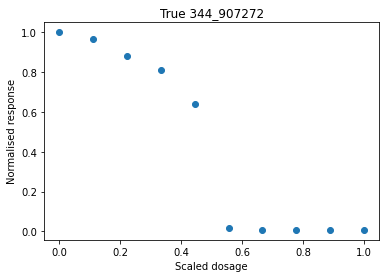

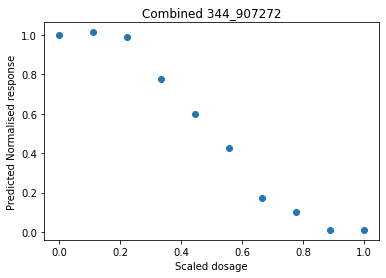

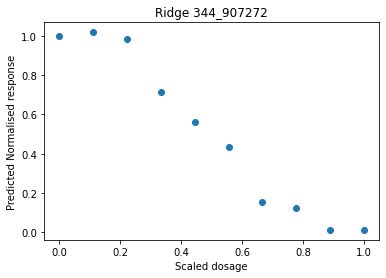

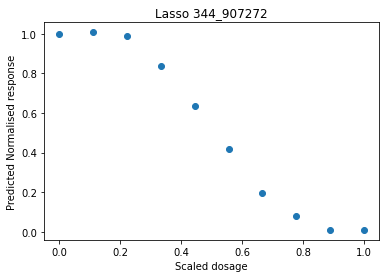

In [105]:
showTestPredResponses('344_907272')

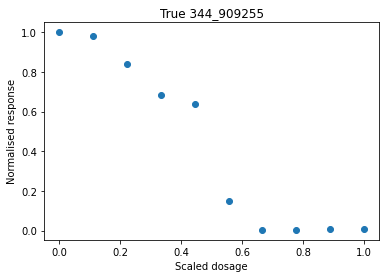

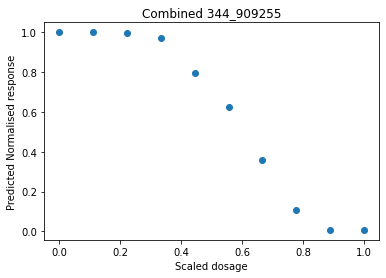

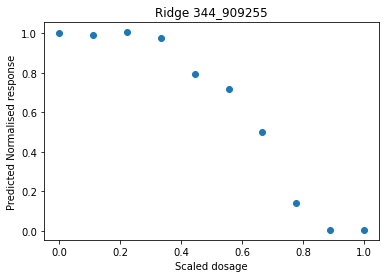

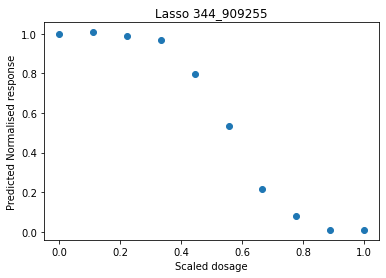

In [106]:
showTestPredResponses('344_909255')

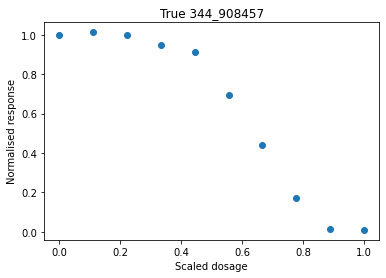

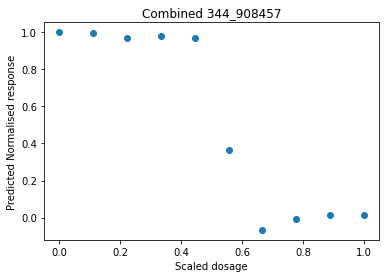

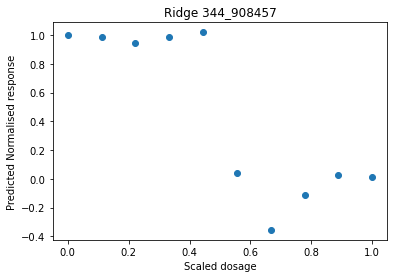

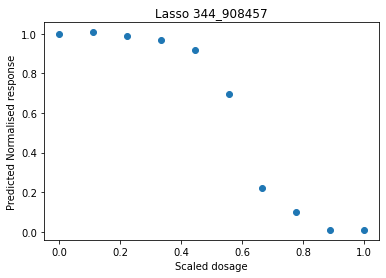

In [107]:
showTestPredResponses('344_908457')

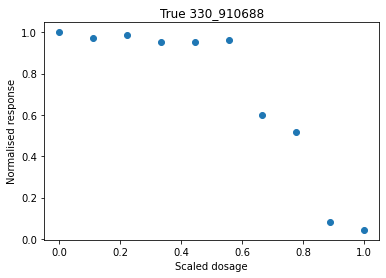

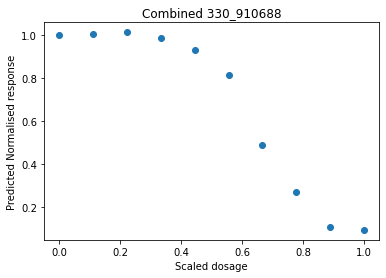

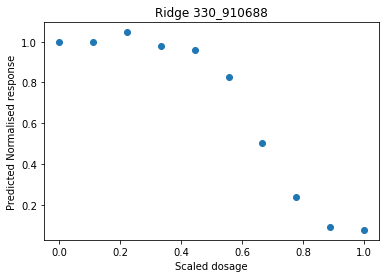

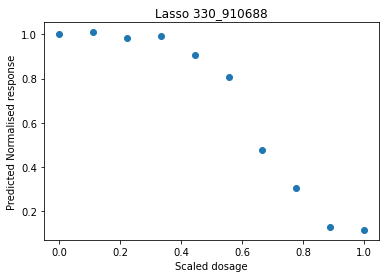

In [108]:
showTestPredResponses('330_910688')